In [1]:
%matplotlib inline
%load_ext rpy2.ipython
import xarray as xr
import pandas as pd
import numpy as np
import os
import glob
import netCDF4 
import matplotlib.pyplot as plt
import warnings
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import STAP
from rpy2.rinterface_lib.embedded import RRuntimeError

warnings.simplefilter('ignore')
plt.style.use('ggplot')
numpy2ri.activate()

# Tercile plots for GOTM output

This notebook compares results from GOTM using the ERA-Interim data as "pseudo-observations" against predictions made using S4 forecasts for each season in each year (with a 13 momnth warm-up period). See the `Readme` file here:

    shared/WATExR/SimplyQ_GOTM_run_results/Readme.txt
    
for further details. The aim is to create tercile plots for each season in each year for three variables: temperature, ice thickness and surface mixed layer depth.

## 1. User input

In [2]:
# Define seasons
seasons_dict = {'winter':[12, 1, 2],
                'spring':[3, 4, 5],
                'summer':[6, 7, 8],
                'fall':  [9, 10, 11],
               }

# Paths to datasets
store_obs_nc_path = r'/home/jovyan/shared/WATExR/SimplyQ_GOTM_run_results/store_full_eraInterim.nc'
vanem_obs_nc_path = r'/home/jovyan/shared/WATExR/SimplyQ_GOTM_run_results/vanem_full_eraInterim.nc'

store_mod_fold = r'/home/jovyan/shared/WATExR/SimplyQ_GOTM_run_results/Storefjorden'
vanem_mod_fold = r'/home/jovyan/shared/WATExR/SimplyQ_GOTM_run_results/Vanemfjorden'

# Pat dict with values as (obs, mod)
path_dict = {'store':(store_obs_nc_path, store_mod_fold),
             'vanem':(vanem_obs_nc_path, vanem_mod_fold),
            }

## 2. Utility functions

In [3]:
def gotm_vars_to_dataframe(ds):
    """ Processes/aggregates the different variables of interest and returns a dataframe
        with one column per variable.
        
    Args:
        ds: Xarray dataset of GOTM "pseudo-observations"
        
    Returns:
        Dataframe
    """
    # Get vars of interest
    # Hice is stored as a 4D variable (time, lat, lon, z), but it's actually
    # 3D (time, lat, lon), with all values in the surface 'row'. Calculating
    # the means/medians therefore gives misleading values (due to all the 
    # zeros). Instead, set 0 => NaN, aggregate, then fill NaNs again    
    hice = ds['Hice'].values
    hice[hice == 0] = np.nan
    ds['Hice'].values = hice

    # Use means (overall depths where relevant) for now
    ds = ds[['temp', 'Hice', 'mld_surf']].mean(dim=['lat', 'lon', 'z'])
    df = ds.to_dataframe()
    df.fillna(0, inplace=True)
    df.index = pd.to_datetime(df.index.date)
    
    return df    

As far as possible, I'd like to use the `visualizeR` functions for generating the pots, in order to be consistent with other work. I'll do most of the data processing in Python, then pass variables over to R and re-structure for the crucial last steps in each loop.

In [4]:
r_fct = """    
tercile_plot <- function(var_name, long_name, st_dates, end_dates, obs_values, mod_values, out_path){

    # Function to reformat GOTM data for use in visualizeR's tercilePlot function.
    # Uses an example of the 'obs' and 'mod' output for a single variable saved
    # from the notebook here:
    #
    #     WATExR/Norway_Morsa/MetData_Processing/notebooks/03_validation_tercile_plots.ipynb
    #
    # Args:
    #     var_name:   Str. Short name for variable
    #     long_name:  Str. Long name for variable
    #     st_dates:   Numpy array of strings with dates in format 'YYYY-MM-DD'
    #     end_dates:  Numpy array of strings with dates in format 'YYYY-MM-DD'
    #     obs_values: Numpy array of floats
    #     mod_values: Numpy array of floats
    #     out_path:   Str. Path to PDF to be created
    # 
    # Returns:
    #     None. PDF is saved to path specified

    suppressPackageStartupMessages(library(Cairo))
    suppressPackageStartupMessages(library(visualizeR))
    
    # Convert dates to vectors with POSIX format
    st_dates <- c(st_dates)
    st_dates <- strptime(st_dates, "%Y-%m-%d")
    end_dates <- c(end_dates)
    end_dates <- strptime(end_dates, "%Y-%m-%d")

    # Obs values as R array
    obs_values <- array(obs_values)
    attr(obs_values, "dimensions") <- c("time")

    # Mod values as R array
    mod_values <- array(mod_values, dim = c(15, length(st_dates)))
    attr(mod_values, "dimensions") <- c("member", "time")

    # Load data "templates" from original tercile plot script
    obs_temp <- get(load("obs_data_template.rda"))
    mod_temp <- get(load("mod_data_template.rda"))

    # Update obs "template" with new data
    obs_temp$Variable$varName <- var_name
    attr(obs_temp$Variable, 'longname') <- long_name
    obs_temp$Data <- obs_values
    obs_temp$Dates$start <- st_dates
    obs_temp$Dates$end <- end_dates

    # Update mod "template" with new data
    mod_temp$Variable$varName <- var_name
    attr(mod_temp$Variable, 'longname') <- long_name
    mod_temp$Data <- mod_values
    mod_temp$Dates$start <- st_dates
    mod_temp$Dates$end <- end_dates
    mod_temp$InitializationDates <- NULL

    # Make tercile plot
    CairoPDF(file = out_path, width = 10)
    tercilePlot(obs = redim(obs_temp), hindcast = redim(mod_temp))
    dev.off()
}
"""

# Load R function for making tercile plots
r_pkg = STAP(r_fct, "r_pkg")

## 3. Data processing

In [5]:
# Loop over basins
for basin in path_dict.keys():
    print(f'Processing: {basin}fjorden')
    obs_path = path_dict[basin][0]
    mod_fold = path_dict[basin][1]
    
    # Read obs
    obs_ds = xr.open_dataset(obs_path, drop_variables='z')
    obs_df = gotm_vars_to_dataframe(obs_ds)  
    
    # Loop over seasons
    for season in seasons_dict.keys():
        print(f'  {season}')
        print(f'    Getting S4 data')      
        
        mem_list = []
        
        # Loop over S4 members
        for mem in range(0, 15):
            # Get S4 data for member (for all years in this season)
            search_path = os.path.join(mod_fold, f'{basin}_*_{season}_{mem}.nc')
            flist = sorted(glob.glob(search_path))

            # Loop over files for each year
            year_list = []
            for fpath in flist:
                mem_yr_ds = xr.open_dataset(fpath, drop_variables='z')
                mem_yr_df = gotm_vars_to_dataframe(mem_yr_ds)
                
                # Get just the months of interest
                months = seasons_dict[season]
                mem_yr_df = mem_yr_df.iloc[-100:] # Ensures we don't gets months from the previous year "warm-up" too
                mem_yr_df['month'] = mem_yr_df.index.month
                mem_yr_df = mem_yr_df.query('month in @months')
                del mem_yr_df['month']
                
                year_list.append(mem_yr_df)
                
            # Build single df for this member for all years
            mem_df = pd.concat(year_list, axis='rows')
            
            # Create multi-index with member
            iterables = [mem_df.columns, [mem + 1,]]
            mem_df.columns = pd.MultiIndex.from_product(iterables, 
                                                        names=['variable', 'member'])            
            mem_list.append(mem_df)
            
        # Build a dataframe of all members
        mod_df = pd.concat(mem_list, axis='columns')  
        
        # Get matching dates from obs df
        obs_df_seas = obs_df[obs_df.index.isin(mod_df.index)]
        
        assert len(obs_df_seas) == len(mod_df), f'Dataframe lengths do not match for {season}.'
        
        # Loop over variables            
        for variable in ['temp', 'Hice', 'mld_surf']:
            # Get data series
            obs = obs_df_seas[variable]
            mod = mod_df[variable]
            
            try:    
                # Extract components for passing to R
                long_name = obs_ds[variable].attrs['long_name']
                st_dates = obs.index.strftime('%Y-%m-%d').values
                end_dates = (obs.index + pd.DateOffset(days=1)).strftime('%Y-%m-%d').values # Shifted by 1 day from 'start'
                obs_values = obs.values
                mod_values = mod.values.T
                out_pdf = f'./pdfs/gotm_terc_plot_{basin}_{variable}_{season}.pdf'

                # Make plot using R function
                r_pkg.tercile_plot(variable, long_name, st_dates, end_dates, 
                                   obs_values, mod_values, out_pdf)  
                print(f'      Finished plot for: {variable}')
                
            except RRuntimeError:
                print(f'      Skipping {variable} as insufficient data.')

Processing: storefjorden
  winter
    Getting S4 data
      Finished plot for: temp
      Finished plot for: Hice
      Finished plot for: mld_surf
  spring
    Getting S4 data
      Finished plot for: temp
      Finished plot for: Hice
      Finished plot for: mld_surf
  summer
    Getting S4 data


R[write to console]: Error in Auc(pred[no.nan], obs[no.nan], handle.na = "only.complete.pairs") : 
  need at least one event and one non-event
Calls: <Anonymous> -> tercilePlot -> rocss.fun -> Auc



      Finished plot for: temp


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: no DISPLAY variable so Tk is not available 



      Skipping Hice as insufficient data.
      Finished plot for: mld_surf
  fall
    Getting S4 data
      Finished plot for: temp


R[write to console]: Error in Auc(pred[no.nan], obs[no.nan], handle.na = "only.complete.pairs") : 
  need at least one event and one non-event
Calls: <Anonymous> -> tercilePlot -> rocss.fun -> Auc



      Skipping Hice as insufficient data.
      Finished plot for: mld_surf
Processing: vanemfjorden
  winter
    Getting S4 data
      Finished plot for: temp
      Finished plot for: Hice
      Finished plot for: mld_surf
  spring
    Getting S4 data
      Finished plot for: temp
      Finished plot for: Hice
      Finished plot for: mld_surf
  summer
    Getting S4 data


R[write to console]: Error in Auc(pred[no.nan], obs[no.nan], handle.na = "only.complete.pairs") : 
  need at least one event and one non-event
Calls: <Anonymous> -> tercilePlot -> rocss.fun -> Auc



      Finished plot for: temp
      Skipping Hice as insufficient data.
      Finished plot for: mld_surf
  fall
    Getting S4 data
      Finished plot for: temp
      Finished plot for: Hice
      Finished plot for: mld_surf


## 4. Checking

The code below generates a tercile plot using Python, based on my understanding of what the `visualizeR` function is doing. Note that the code below **doesn't make allowances for winter months crossing the year-end boundary**, so it is not expected to produce correct results for winter. However, comparisons for the other seasons seem OK and are enough to convince me that my Python <-> R interaction are working reasonabley.

In [6]:
print(basin, variable, season)

vanem mld_surf fall


In [7]:
obs_ann = obs.groupby(obs.index.year).mean()
obs_quants = obs_ann.quantile([0.33, 0.67])
obs_quants

0.33    12.857717
0.67    14.385505
Name: mld_surf, dtype: float64

In [8]:
# Build bins for terciles
terc_bins = obs_quants.values
terc_bins = np.insert(terc_bins, 0, -np.inf)
terc_bins = np.append(terc_bins, np.inf)
terc_bins

array([       -inf, 12.85771742, 14.3855051 ,         inf])

In [9]:
mod_ann = mod.groupby(mod.index.year).mean()
mod_ann.head()

member,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1981,13.627802,14.037033,11.573297,11.663077,12.542088,14.523517,11.815495,14.538132,13.084945,12.790549,14.247912,14.360660,12.506594,14.780330,12.414725
1982,12.596374,15.229231,13.103736,14.164395,12.936704,13.606923,15.701099,13.911758,14.698901,14.339780,13.694615,13.957692,15.076813,14.657143,16.442308
1983,14.369011,12.535824,12.840659,13.631978,13.066154,13.231099,12.613077,14.897253,14.346044,12.320769,10.844615,13.648682,11.615055,13.001429,12.379230
1984,13.602747,12.239341,15.717802,13.268682,12.026374,14.711429,15.058022,15.049670,11.454286,12.700769,14.790770,12.959670,11.878132,15.126923,12.070220
1985,10.911428,12.905385,13.640329,10.366484,13.460770,16.897472,14.907692,13.110000,11.926154,13.377253,12.583846,13.262418,12.001319,15.329451,14.709341


In [10]:
# Get terciles
df_list = []
for year in mod_ann.index:
    terc_df = pd.cut(mod_ann.loc[year], 
                     bins=terc_bins,
                     labels=['Below normal', 'Near normal', 'Above normal'])

    terc_prob = 100 * terc_df.value_counts() / 15
    df_list.append(terc_prob)
    
df = pd.concat(df_list, axis='columns').T

df.head()

,Below normal,Near normal,Above normal
1981,46.666667,33.333333,20.000000
1982,6.666667,53.333333,40.000000
1983,46.666667,46.666667,6.666667
1984,40.000000,20.000000,40.000000
1985,33.333333,40.000000,26.666667


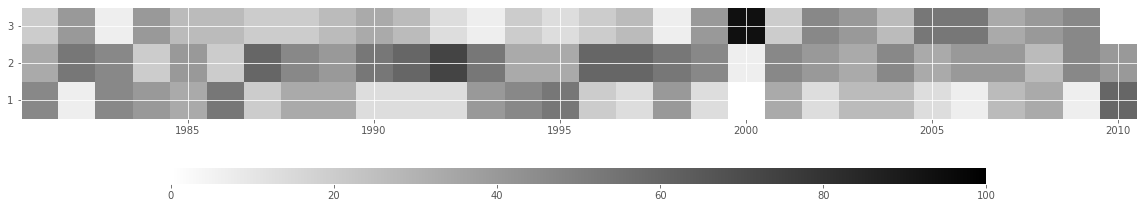

In [11]:
data = df.T.iloc[::-1].values
fig = plt.figure(figsize=(20,6))
plt.imshow(data, cmap='gray_r', extent=[1980.5,2010.5,0.5,3.5], vmin=0, vmax=100)
plt.colorbar(orientation="horizontal", fraction=0.05, aspect=50)

##  Appendix

The following "interactive" code was used to develop and test the R `tercile_plot` function.

In [12]:
## Get data for testing
#obs = obs_df_seas["temp"]
#mod = mod_df["temp"]
#
## Extract components for passing to R
#var_name = 'temp'
#long_name = 'Temperature'
#st_dates = obs.index.strftime('%Y-%m-%d').values
#end_dates = (obs.index + pd.DateOffset(days=1)).strftime('%Y-%m-%d').values
#obs_values = obs.values
#mod_values = mod.values.T

In [13]:
#%%R -i var_name,long_name,st_dates,end_dates,obs_values,mod_values -o mod_temp,obs_temp
#
#suppressPackageStartupMessages(library(Cairo))
#suppressPackageStartupMessages(library(visualizeR))
#
#st_dates <- c(st_dates)
#st_dates <- strptime(st_dates, "%Y-%m-%d")
#end_dates <- c(end_dates)
#end_dates <- strptime(end_dates, "%Y-%m-%d")
#
#obs_values <- array(obs_values)
#attr(obs_values, "dimensions") <- c("time")
#
#mod_values <- array(mod_values, dim = c(15, length(st_dates)))
#attr(mod_values, "dimensions") <- c("member", "time")
#
#obs_temp <- get(load("obs_data_template.rda"))
#mod_temp <- get(load("mod_data_template.rda"))
#
#obs_temp$Variable$varName <- var_name
#attr(obs_temp$Variable, 'longname') <- long_name
#obs_temp$Data <- obs_values
#obs_temp$Dates$start <- st_dates
#obs_temp$Dates$end <- end_dates
#
#mod_temp$Variable$varName <- var_name
#attr(mod_temp$Variable, 'longname') <- long_name
#mod_temp$Data <- mod_values
#mod_temp$Dates$start <- st_dates
#mod_temp$Dates$end <- end_dates
#mod_temp$InitializationDates <- NULL
#
#CairoPDF(file = 'test', width = 10)
#tercilePlot(obs = redim(obs_temp), hindcast = redim(mod_temp))